In [183]:
import os
import pandas as pd

ROOT_PATH = '/sources/dataset/'
df = pd.read_csv(os.path.join(ROOT_PATH, 'train.csv'))
landmarks = os.listdir(os.path.join(ROOT_PATH, 'train_landmark_files'))

In [184]:
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [186]:
paths = df.path.values
p_ids = df.participant_id.values
s_ids = df.sequence_id.values
labels = df.sign.values

In [187]:
sample = pd.read_parquet(os.path.join(ROOT_PATH, paths[0]))
sample

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [ ]:
import numpy as np

print(np.unique(sample.frame))
print(np.unique(sample.type))

In [ ]:
print('landmark count')
print('# face', len(np.unique(sample[sample.type=='face']['landmark_index'])))
print('# pose', len(np.unique(sample[sample.type=='pose']['landmark_index'])))
print('# lh', len(np.unique(sample[sample.type=='left_hand']['landmark_index'])))
print('# rh', len(np.unique(sample[sample.type=='right_hand']['landmark_index'])))

In [ ]:
for p_id in np.unique(p_ids):
    print(f"p_id: {p_id}, # labels: {len(np.unique(df[df.participant_id==p_id].sign))}, # samples: {len(df[df.participant_id==p_id])}")
    

In [ ]:
print("label count")
for p_id in np.unique(p_ids):
    label_cnt = df[df.participant_id==p_id].sign.value_counts()
    print(f'p_id: {p_id}, max: {label_cnt.max()}, min: {label_cnt.min()}, mean: {label_cnt.mean()}')

In [ ]:
from tqdm import tqdm
# test_df = df.iloc[:10]
feat_df = []
for item in tqdm(df.itertuples()):
    path, p_id, s_id, label = item.path, item.participant_id, item.sequence_id, item.sign
    sample = pd.read_parquet(os.path.join(ROOT_PATH, path))
    
    frames = np.unique(sample.frame)
    start_frame = min(frames)
    end_frame = max(frames)
    total_frames = end_frame - start_frame + 1

    length = len(sample)

    tmp = pd.DataFrame([[start_frame, end_frame, total_frames, length]], columns=['start_frame', 'end_frame', 'total_frames', 'length'], dtype=int)
    feat_df.append(tmp)

In [ ]:
feat_df = pd.concat(feat_df, ignore_index=True)

In [ ]:
new_df = pd.concat([df, feat_df], axis=1)
new_df

In [ ]:
new_df.to_csv(os.path.join(ROOT_PATH, 'train_w_duration.csv'))

In [ ]:
new_df = pd.read_csv(os.path.join(ROOT_PATH, 'train_w_duration.csv'))

new_df_indexed = new_df.set_index('sign')
from collections import defaultdict

info = defaultdict()
percentile = [0, 1, 5, 25, 50, 75, 95, 99, 100]
for s in labels:
    tmp = new_df_indexed.loc[s]
    p_start_frame = list(map(int, np.percentile(tmp.start_frame, percentile, method='nearest')))
    p_end_frame = list(map(int, np.percentile(tmp.end_frame, percentile, method='nearest')))
    p_total_frames = list(map(int, np.percentile(tmp.total_frames, percentile, method='nearest')))
    p_length = list(map(int, np.percentile(tmp.length, percentile, method='nearest')))

    min_start_frame, max_start_frame, mean_start_frame, std_start_frame = p_start_frame[0], p_start_frame[-1], int(np.mean(tmp.start_frame)), int(np.std(tmp.start_frame))
    min_end_frame, max_end_frame, mean_end_frame, std_end_frame = p_end_frame[0], p_end_frame[-1], int(np.mean(tmp.end_frame)), int(np.std(tmp.end_frame))
    min_total_frames, max_total_frames, mean_total_frames, std_total_frames = p_total_frames[0], p_total_frames[-1], int(np.mean(tmp.total_frames)), int(np.std(tmp.total_frames))
    min_length, max_length, mean_length, std_length = p_length[0], p_length[-1], int(np.mean(tmp.length)), int(np.std(tmp.length))

    info[s] = {'start_frame': {'min': min_start_frame, 'max': max_start_frame, 'mean': mean_start_frame, 'std': std_start_frame, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_start_frame}, \
                'end_frame': {'min': min_end_frame, 'max': max_end_frame, 'mean': mean_end_frame, 'std': std_end_frame, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_end_frame}, \
                'total_frames': {'min': min_total_frames, 'max': max_total_frames, 'mean': mean_total_frames, 'std': std_total_frames, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_total_frames}, \
                'length': {'min': min_length, 'max': max_length, 'mean': mean_length, 'std': std_length, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_length}}
    
    

In [ ]:
import json

with open(os.path.join(ROOT_PATH, "sign_info.json"), "w") as outfile:
    json.dump(info, outfile, indent=4)


### Face landmark index

In [133]:
face_sample = sample.loc[(sample.type=='face') & (sample.frame==114)]
face_sample

,frame,row_id,type,landmark_index,x,y,z
16290,114,114-face-0,face,0,0.494765,0.435277,-0.052198
16291,114,114-face-1,face,1,0.486463,0.389259,-0.077992
16292,114,114-face-2,face,2,0.488000,0.405440,-0.047902
16293,114,114-face-3,face,3,0.474448,0.354604,-0.050292
16294,114,114-face-4,face,4,0.486221,0.377098,-0.080197
...,...,...,...,...,...,...,...
16753,114,114-face-463,face,463,0.529635,0.334584,0.025208
16754,114,114-face-464,face,464,0.520673,0.335899,0.015872
16755,114,114-face-465,face,465,0.513914,0.336745,0.005295
16756,114,114-face-466,face,466,0.595412,0.335106,0.035154


In [161]:
FACE_X, FACE_Y, FACE_Z = np.array(face_sample.x), np.array(face_sample.y), np.array(face_sample.z)

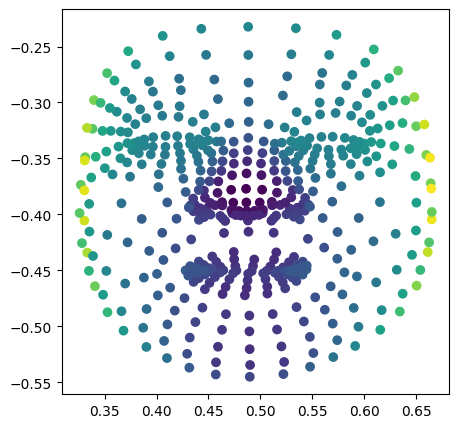

In [144]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(FACE_X[1:], -FACE_Y[1:], c=FACE_Z[1:])
plt.show()

In [181]:
FACE_LM = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109]
LEYE_LM = [130, 247, 30, 29, 27, 28, 56, 190, 243, 112, 26, 22, 23, 24, 110, 25]
REYE_LM = [359, 467, 260, 259, 257, 258, 286, 414, 463, 341, 256, 252, 253, 254, 339, 255]
NOSE_LM = [6, 197, 195, 5, 4, 1, 19, 94, 2, 164, 49, 102, 64, 279, 331, 294]
LIPSOUT_LM = [0, 267, 269, 270, 409, 287, 375, 321, 405, 314, 17, 84, 181, 91, 146, 57, 185, 40, 39, 37]
LIPSIN_LM = [13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78, 191, 80, 81, 82]
SPECIAL_LM = [9, 123, 36, 50, 352, 280, 266, 199, 200]

FACE_SELECTED = []
# SELECTED.extend(FACE_LM)
# SELECTED.extend(LEYE_LM)
# SELECTED.extend(REYE_LM)
# SELECTED.extend(NOSE_LM)
FACE_SELECTED.extend(LIPSOUT_LM)
FACE_SELECTED.extend(LIPSIN_LM)
# SELECTED.extend(SPECIAL_LM)


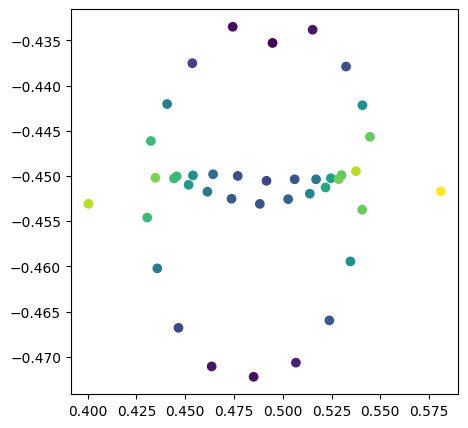

In [145]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(FACE_X[FACE_SELECTED], -FACE_Y[FACE_SELECTED], c=FACE_Z[FACE_SELECTED])
plt.show()

### Pose landmark index

In [152]:
pose_sample = sample.loc[(sample.type=='pose') & (sample.frame==114)]
pose_sample

,frame,row_id,type,landmark_index,x,y,z
16779,114,114-pose-0,pose,0,0.504804,0.388945,-1.356693
16780,114,114-pose-1,pose,1,0.538818,0.331946,-1.255185
16781,114,114-pose-2,pose,2,0.563865,0.335063,-1.254890
16782,114,114-pose-3,pose,3,0.589226,0.339258,-1.254672
16783,114,114-pose-4,pose,4,0.459722,0.327606,-1.291179
16784,114,114-pose-5,pose,5,0.427734,0.326663,-1.290641
16785,114,114-pose-6,pose,6,0.394957,0.326476,-1.291675
16786,114,114-pose-7,pose,7,0.629848,0.373278,-0.594531
16787,114,114-pose-8,pose,8,0.348324,0.358740,-0.750409
16788,114,114-pose-9,pose,9,0.553402,0.461552,-1.108975


In [162]:
POSE_X, POSE_Y, POSE_Z = np.array(pose_sample.x), np.array(pose_sample.y), np.array(pose_sample.z)

In [201]:
PNOSE_LM = [0]
PFACE_LM = [8, 6, 5, 4, 1,2,3,7]
BODY_LM = [11, 12, 24 ,23]
ARM_LM = [14, 16, 22, 20, 18, 13, 15, 21, 19, 17]

POSE_SELECTED = []
POSE_SELECTED.extend(PNOSE_LM)
POSE_SELECTED.extend(PFACE_LM)
POSE_SELECTED.extend(BODY_LM)
POSE_SELECTED.extend(ARM_LM)

IndexError: index 24 is out of bounds for axis 0 with size 13

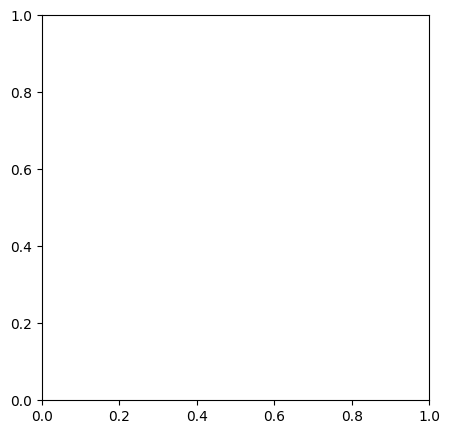

In [202]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(POSE_X[POSE_SELECTED], -POSE_Y[POSE_SELECTED], c=POSE_Z[POSE_SELECTED])
plt.show()

### Overall landmark

In [196]:
overall_sample = sample[sample.frame==114]
overall_sample

,frame,row_id,type,landmark_index,x,y,z


In [197]:
X, Y, Z = overall_sample.x, overall_sample.y, overall_sample.z

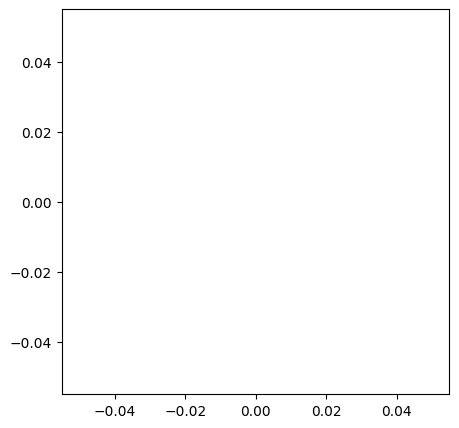

In [198]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(X[:], -Y[:], c=Z[:])
plt.show()

In [199]:
FACE_X, FACE_Y, FACE_Z = FACE_X[FACE_SELECTED], FACE_Y[FACE_SELECTED], FACE_Z[FACE_SELECTED]
POSE_X, POSE_Y, POSE_Z = POSE_X[POSE_SELECTED], POSE_Y[POSE_SELECTED], POSE_Z[POSE_SELECTED]

IndexError: index 267 is out of bounds for axis 0 with size 40

In [ ]:
lh_sample = sample.loc[(sample.type=='left_hand') & (sample.frame==114)]
rh_sample = sample.loc[(sample.type=='right_hand') & (sample.frame==114)]

In [ ]:
LH_X, LH_Y, LH_Z = lh_sample.x, lh_sample.y, lh_sample.z
RH_X, RH_Y, RH_Z = rh_sample.x, rh_sample.y, rh_sample.z

In [ ]:
X, Y, Z = np.concatenate([FACE_X, POSE_X, LH_X, RH_X]), np.concatenate([FACE_Y, POSE_Y, LH_Y, RH_Y]), np.concatenate([FACE_Z, POSE_Z, LH_Z, RH_Z])
len(X)

95

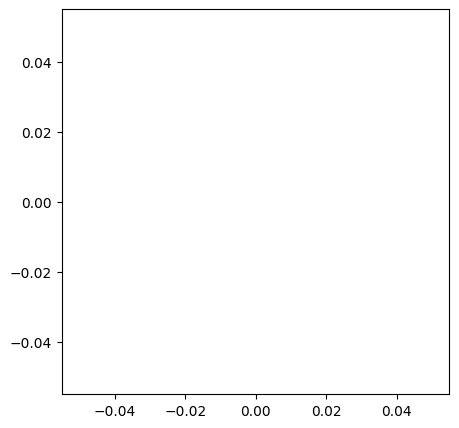

In [200]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(X[:], -Y[:], c=Z[:])
plt.show()

In [193]:
print(FACE_X.size)
print(POSE_X.size)
print(LH_X.size)
print(RH_X.size)

40
13
21
21
